# Pre-processing the data


In [0]:
import numpy as np
import pandas as pd

## Load the data

Download all data-sets

In [0]:
data = pd.read_csv('https://open-covid-19.github.io/data/data.csv', parse_dates=['Date'])
weather = pd.read_csv('https://open-covid-19.github.io/data/weather.csv', parse_dates=['Date'])
mobility = pd.read_csv('https://open-covid-19.github.io/data/mobility.csv', parse_dates=['Date'])
data_categories = pd.read_csv('https://open-covid-19.github.io/data/data_categories.csv', parse_dates=['Date'])

Remove irrelevant features

In [0]:
data.drop(columns=['CountryName', 'RegionCode','RegionName', 'CountryCode','Population','Latitude','Longitude'], inplace=True)
weather.drop(columns=['Distance', 'Station','Snowfall','Rainfall'], inplace=True)
data_categories.drop(columns=['NewCases', 'NewDeaths'],inplace=True)

Load the state-wise data

In [0]:
data = data[data['Key'].notna()]
data_regions = data[data['Key'].str.contains('US_')]
len(data_regions)

3025

Load the mobility data

In [0]:
mobility = mobility[mobility['Key'].notna()]
mobility_regions = mobility[mobility['Key'].str.contains('US_')]
mobility_regions = mobility_regions.drop_duplicates(subset=['Key', 'Date'])
len(mobility_regions)

3672

Load the weather data

In [0]:
weather = weather[weather['Key'].notna()]
weather_regions = weather[weather['Key'].str.contains('US_')]
len(weather_regions)

5330

Load the categories data (number of new and current cases based on their severity level)

In [0]:
data_categories = data_categories[data_categories['Key'].notna()]
data_categories_regions = data_categories[data_categories['Key'].str.contains('US_')]
len(data_categories_regions)

2260

## Merge data-sets

In [0]:
dw_merged = pd.merge(data_regions, weather_regions, on=['Key', 'Date'], how='outer')
dwrc_merged = pd.merge(dw_merged, data_categories_regions, on=['Key', 'Date'], how='outer')
dwrcm_merged = pd.merge(dwrc_merged, mobility_regions, on=['Key', 'Date'], how='outer')

In [0]:
first_case = dwrcm_merged[dwrcm_merged['Confirmed'].notna()]['Date'].min()
dwrcm_merged_first = dwrcm_merged[dwrcm_merged['Date'] >= first_case]

In [0]:
dwrcm_merged_first['Deaths'].fillna(0, inplace=True)
dwrcm_merged_first['Confirmed'].fillna(0, inplace=True)

dwrcm_merged_first['RetailAndRecreation'].fillna(0, inplace=True)
dwrcm_merged_first['GroceryAndPharmacy'].fillna(0, inplace=True)
dwrcm_merged_first['Parks'].fillna(0, inplace=True)
dwrcm_merged_first['TransitStations'].fillna(0, inplace=True)
dwrcm_merged_first['Workplaces'].fillna(0, inplace=True)
dwrcm_merged_first['Residential'].fillna(0, inplace=True)

dwrcm_merged_first['NewMild'].fillna(0, inplace=True)
dwrcm_merged_first['NewSevere'].fillna(0, inplace=True)
dwrcm_merged_first['NewCritical'].fillna(0, inplace=True)
dwrcm_merged_first['CurrentlyMild'].fillna(0, inplace=True)
dwrcm_merged_first['CurrentlySevere'].fillna(0, inplace=True)
dwrcm_merged_first['CurrentlyCritical'].fillna(0, inplace=True)

dwrcm_merged_first.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Date,Key,Confirmed,Deaths,MinimumTemperature,MaximumTemperature,NewMild,NewSevere,NewCritical,CurrentlyMild,CurrentlySevere,CurrentlyCritical,RetailAndRecreation,GroceryAndPharmacy,Parks,TransitStations,Workplaces,Residential
0,2020-01-22,US_WA,1.0,0.0,-0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,US_WA,1.0,0.0,0.2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,US_WA,1.0,0.0,1.1,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,US_WA,1.0,0.0,0.7,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-26,US_WA,1.0,0.0,0.5,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Calculate the daily rate of change

In [0]:
dwrcm_merged_first['ConfirmedRateChange'] = dwrcm_merged_first['Confirmed']
dwrcm_merged_first['DeathsRateChange'] = dwrcm_merged_first['Deaths']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
all_keys = pd.unique(dwrcm_merged_first['Key'])
all_dates = pd.unique(dwrcm_merged_first['Date'])

In [0]:
def change_per_day(current_col_name,new_col_name):
  for key in all_keys:
    for idx,date in enumerate(all_dates):
      condition = (dwrcm_merged_first['Key'] == key) & (dwrcm_merged_first['Date'] == all_dates[idx])

      if idx == 0:
        continue
      condition_prev = (dwrcm_merged_first['Key'] == key) & (dwrcm_merged_first['Date'] == all_dates[idx-1])

      current = dwrcm_merged_first.loc[condition,[current_col_name]].values
      previous = dwrcm_merged_first.loc[condition_prev,[current_col_name]].values
      
      if previous:
          update_val =  (current - previous) / previous
      elif current == 0 and previous == 0:
          update_val = 0
      else:
          # update_val = float('inf')
          update_val = current
          
      dwrcm_merged_first.loc[condition,[new_col_name]] = update_val

In [0]:
change_per_day('Confirmed','ConfirmedRateChange')
change_per_day('Deaths','DeathsRateChange')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app


In [0]:
corona_df = dwrcm_merged_first.drop(columns=['Deaths','Confirmed'])

Filter by date

In [0]:
corona_df = corona_df[(corona_df['Date'] >= '2020-02-28') & (corona_df['Date'] <= '2020-04-25')]

## Convert to categorical data

In [0]:
def convert_cat(cols_to_categorize, cols_cut_on, percentiles, labels):

    corona_df_desc = corona_df.describe(percentiles=percentiles)
    cols_cat_on = corona_df_desc.loc[cols_cut_on, cols_to_categorize]

    for col in cols_to_categorize:
        bin = cols_cat_on[col]
        bin[0] = -100
        temp = pd.cut(corona_df[col],bins=bin,labels=labels)
        corona_df.insert(len(corona_df.columns), col + "_cat", temp)

convert_cat(['MinimumTemperature','MaximumTemperature','RetailAndRecreation','GroceryAndPharmacy','Parks','TransitStations','Workplaces','Residential','ConfirmedRateChange'], \
            ['min','20%','40%','60%','80%','max'], [.2, .4, .6, .8], [0, 1, 2, 3, 4]) # ['Very Low','Low','Medium','High','Very High']

convert_cat(['NewMild','NewSevere','NewCritical','CurrentlyMild','CurrentlySevere','CurrentlyCritical'], \
            ['min','60%','70%','80%','90%','max'], [.6, .7, .8, .9], [0, 1, 2, 3, 4]) # ['Very Low','Low','Medium','High', 'Very High']

corona_df.head()

,Date,Key,MinimumTemperature,MaximumTemperature,NewMild,NewSevere,NewCritical,CurrentlyMild,CurrentlySevere,CurrentlyCritical,RetailAndRecreation,GroceryAndPharmacy,Parks,TransitStations,Workplaces,Residential,ConfirmedRateChange,DeathsRateChange,MinimumTemperature_cat,MaximumTemperature_cat,RetailAndRecreation_cat,GroceryAndPharmacy_cat,Parks_cat,TransitStations_cat,Workplaces_cat,Residential_cat,ConfirmedRateChange_cat,NewMild_cat,NewSevere_cat,NewCritical_cat,CurrentlyMild_cat,CurrentlySevere_cat,CurrentlyCritical_cat
37,2020-02-28,US_WA,-1.2,7.0,6.0,1.0,0.0,6.0,1.0,0.0,7.0,2.0,31.0,6.0,3.0,-2.0,3.500000,1.00,1,0,4,3,3,4,4,0,4,0,0,0,0,0,0
38,2020-02-29,US_WA,-5.1,0.6,7.0,1.0,0.0,13.0,2.0,1.0,7.0,7.0,31.0,5.0,2.0,-1.0,1.000000,0.25,0,0,4,3,3,4,4,0,4,0,0,0,0,0,0
39,2020-03-01,US_MI,-8.9,1.7,0.0,0.0,0.0,0.0,0.0,0.0,17.0,10.0,57.0,23.0,5.0,-2.0,9.000000,0.00,0,0,4,4,4,4,4,0,4,0,0,0,0,0,0
40,2020-03-01,US_RI,-7.8,3.3,0.0,0.0,0.0,0.0,0.0,0.0,13.0,7.0,-3.0,9.0,5.0,-1.0,1.000000,0.00,0,0,4,3,1,4,4,0,4,0,0,0,0,0,0
41,2020-03-01,US_WA,-5.4,0.6,10.0,2.0,1.0,22.0,4.0,1.0,18.0,10.0,27.0,9.0,2.0,-1.0,0.666667,0.60,0,0,4,4,3,4,4,0,4,0,0,0,0,0,0


In [0]:
corona_df[corona_df['DeathsRateChange'] > 0]['DeathsRateChange'].describe()

count    1500.000000
mean        0.265558
std         0.447283
min         0.005682
25%         0.070234
50%         0.130246
75%         0.268527
max         9.000000
Name: DeathsRateChange, dtype: float64

In [0]:
death_rate_change_cat = pd.cut(corona_df['DeathsRateChange'],bins=[-1, 0.00001, 0.129882, 0.224314, 0.412724, 9.000000],labels=[0, 1, 2, 3, 4]) # ['Zero','Very Low','Low','Medium','High']
death_rate_change_cat.value_counts()
corona_df.insert(len(corona_df.columns), 'DeathsRateChange_cat', death_rate_change_cat)

## Ready the data for model training and testing

In [0]:
corona_df.to_csv("corona_categorized.csv")

In [0]:
input = corona_df[['NewMild_cat', 'NewSevere_cat', 'NewCritical_cat', 'CurrentlyMild_cat', 'CurrentlySevere_cat',
       'CurrentlyCritical_cat', 'RetailAndRecreation_cat', 'GroceryAndPharmacy_cat',
       'Parks_cat', 'TransitStations_cat', 'Workplaces_cat', 'Residential_cat',
       'DeathsRateChange_cat']]
output = corona_df['ConfirmedRateChange_cat'] 

In [0]:
input.columns

Index(['NewMild_cat', 'NewSevere_cat', 'NewCritical_cat', 'CurrentlyMild_cat',
       'CurrentlySevere_cat', 'CurrentlyCritical_cat',
       'RetailAndRecreation_cat', 'GroceryAndPharmacy_cat', 'Parks_cat',
       'TransitStations_cat', 'Workplaces_cat', 'Residential_cat',
       'DeathsRateChange_cat'],
      dtype='object')

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(input,output,test_size=0.2, random_state=42, shuffle=True)
print(y_test.value_counts())
print(y_train.value_counts())

1    126
0    126
4    119
3    111
2    110
Name: ConfirmedRateChange_cat, dtype: int64
0    490
2    482
3    480
4    473
1    441
Name: ConfirmedRateChange_cat, dtype: int64


# Apply sklearn library algorithms to get an idea about the performance of different algorithms with default values

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

def run_model(model):
  model.fit(x_train,y_train)
  predicted = model.predict(x_test)
  print(model.score(x_train, y_train))
  print(accuracy_score(y_test, predicted))

In [0]:
run_model(SVC(C=1, kernel='linear'))

0.5832628909551987
0.5726351351351351


In [0]:
run_model(SVC(C=0.1, kernel='poly'))

0.6027049873203719
0.5743243243243243


In [0]:
run_model(SVC(C=10, kernel='rbf'))

0.680050718512257
0.5945945945945946


In [0]:
run_model(KNeighborsClassifier(n_neighbors=10))

0.6373626373626373
0.5591216216216216


In [0]:
run_model(LogisticRegression(max_iter=100))

0.5862214708368555
0.5675675675675675


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
run_model(GaussianNB(var_smoothing=0.1))

0.4370245139475909
0.4172297297297297


In [0]:
run_model(RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=42))

0.8651732882502113
0.5912162162162162


In [0]:
cols = x_train.columns
x_train[cols]= x_train[cols].apply(pd.to_numeric)
x_test[cols]= x_test[cols].apply(pd.to_numeric)
print(x_train.dtypes)

NewMild_cat                int64
NewSevere_cat              int64
NewCritical_cat            int64
CurrentlyMild_cat          int64
CurrentlySevere_cat        int64
CurrentlyCritical_cat      int64
RetailAndRecreation_cat    int64
GroceryAndPharmacy_cat     int64
Parks_cat                  int64
TransitStations_cat        int64
Workplaces_cat             int64
Residential_cat            int64
DeathsRateChange_cat       int64
dtype: object


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [0]:
run_model(XGBClassifier(random_state=42,max_depth=5, learning_rate=0.01,n_estimators=600))


0.6808960270498732
0.597972972972973


# Custom KNN implementation

In [0]:
from sklearn.model_selection import KFold, cross_val_score

In [0]:
class KNN():
  def __init__(self,k=5):
    self.k = k
  
  def euclidean_dist(self,row1, row2):
    dist = 0 
    for i in range(len(row1)-1):
      dist += (row1[i]-row2[i])**2
    return dist**0.5
  
  def get_neighbors(self,train,test_row,k):
    dist =  []
    for row in train : 
      dist.append((row,self.euclidean_dist(row,test_row)))
    dist.sort(key = lambda x : x[1])
    
    neighbors = []
    for i in range(k):
      neighbors.append(dist[i][0])
    return np.array(neighbors)

  #to be used for train-test split
  def predict(self,x_train,y_train,x_test,y_test):
    train_rows = np.column_stack((x_train,y_train))
    test_rows = np.column_stack((x_test,y_test))
    predicted = []
    for row in test_rows:
      neighbors = self.get_neighbors(train_rows,row,self.k)
      predicted_classes = [x[-1] for x in neighbors]
      values,counts = np.unique(predicted_classes,return_counts=True)
      pred = values[np.argmax(counts)]
      predicted.append(pred)
    return np.array(predicted)
  
  def pred(self,train,test):
    predicted = []
    for row in test:
      neighbors = self.get_neighbors(train,row,self.k)
      predicted_classes = [x[-1] for x in neighbors]
      values,counts = np.unique(predicted_classes,return_counts=True)
      pred = values[np.argmax(counts)]
      predicted.append(pred)
    return np.array(predicted)
  
  #to be used for nFold cross validation
  def fit(self,x_train,y_train,nFolds=5):
    X = np.column_stack((x_train,y_train))
    kFold = KFold(n_splits=nFolds)
    scores = []

    for train_indices, test_indices in kFold.split(X):
      train_rows,test_rows = X[train_indices],X[test_indices]
      
      predicted = self.pred(train_rows,test_rows)
      # print(predicted,test_rows[:,-1])
      scores.append(self.evaluate(predicted,test_rows[:,-1]))
    # print(scores)
    return np.array(scores).mean()
      
  @staticmethod
  def evaluate(predicted_labels, correct_labels):
    return sum(p==t for p,t in zip(predicted_labels,correct_labels))/len(predicted_labels)

  @staticmethod
  def classificationReport(y_pred,y_true):
    print(classification_report(y_true,y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true,y_pred))


In [0]:
model = KNN(k=12)
pred =model.predict(x_train,y_train,x_test,y_test )

print('Accuracy:',model.evaluate(pred,y_test))
model.classificationReport(pred,y_test)

Accuracy: 0.5422297297297297
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       126
           1       0.60      0.63      0.62       126
           2       0.39      0.42      0.40       110
           3       0.39      0.32      0.35       111
           4       0.51      0.39      0.44       119

    accuracy                           0.54       592
   macro avg       0.52      0.53      0.52       592
weighted avg       0.53      0.54      0.53       592

Confusion matrix:
[[113   0   1   0  12]
 [  1  80  32  11   2]
 [  3  37  46  15   9]
 [  7  12  34  36  22]
 [ 33   4   5  31  46]]


**Using Train Test Split**

In [0]:
tts = {}
for no in range(1,21):
  model = KNN(k=no)
  pred =model.predict(x_train,y_train,x_test,y_test )
  tts[no]= model.evaluate(pred,y_test)

tts

{1: 0.5489864864864865,
 2: 0.527027027027027,
 3: 0.5489864864864865,
 4: 0.5472972972972973,
 5: 0.5405405405405406,
 6: 0.5709459459459459,
 7: 0.5760135135135135,
 8: 0.5675675675675675,
 9: 0.5658783783783784,
 10: 0.5608108108108109,
 11: 0.5591216216216216,
 12: 0.5422297297297297,
 13: 0.5422297297297297,
 14: 0.543918918918919,
 15: 0.5489864864864865,
 16: 0.5523648648648649,
 17: 0.5506756756756757,
 18: 0.5472972972972973,
 19: 0.5422297297297297,
 20: 0.5489864864864865}

**Using Nfold Cross Validation**

In [0]:
model = KNN(k=7)
X,y = input,output
print(X.shape,y.shape)

model.fit(X,y)

(2958, 13) (2958,)


0.4209379430191613

In [0]:
cv_scores = {}
for no in range(1,21):
  model = KNN(k=no)
  cv_scores[no] =model.fit(X,y,nFolds=10)
cv_scores

{1: 0.385683692166743,
 2: 0.4242888227210261,
 3: 0.418183692166743,
 4: 0.4472915712322492,
 5: 0.447638570774164,
 6: 0.45136738433348605,
 7: 0.45171438387540086,
 8: 0.4598671552908842,
 9: 0.46019354099862575,
 10: 0.4602153000458086,
 11: 0.45276797984425105,
 12: 0.47310123683005034,
 13: 0.4669983967017865,
 14: 0.4774919835089326,
 15: 0.46631126889601465,
 16: 0.477485112230875,
 17: 0.47274507558405865,
 18: 0.4768082913421896,
 19: 0.4757936326156666,
 20: 0.47173270728355476}

In [0]:
list(cv_scores.values())

[0.385683692166743,
 0.4242888227210261,
 0.418183692166743,
 0.4472915712322492,
 0.447638570774164,
 0.45136738433348605,
 0.45171438387540086,
 0.4598671552908842,
 0.46019354099862575,
 0.4602153000458086,
 0.45276797984425105,
 0.47310123683005034,
 0.4669983967017865,
 0.4774919835089326,
 0.46631126889601465,
 0.477485112230875,
 0.47274507558405865,
 0.4768082913421896,
 0.4757936326156666,
 0.47173270728355476]

**Using Scikit Learn Library**



In [0]:
sk_scores = []
sk_range = range(1,21)

for k in sk_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  loss = abs(cross_val_score(knn, X, y, cv=10, scoring='accuracy'))
  sk_scores.append(loss.mean())
sk_scores

[0.4408783783783784,
 0.44558634906092537,
 0.4242842418689877,
 0.4567372881355933,
 0.45606275767292714,
 0.48210833715071005,
 0.4753424186898763,
 0.48007214841960605,
 0.48343334860284015,
 0.48546953733394405,
 0.4857970682546954,
 0.49356733852496565,
 0.4902015574896931,
 0.4956035272560696,
 0.49256756756756753,
 0.49595052679798446,
 0.4969525881814018,
 0.4993243243243244,
 0.507767979844251,
 0.5091216216216218]

**Plot graph**

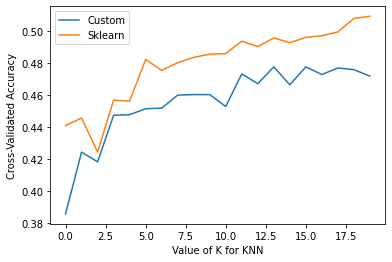

In [0]:
import matplotlib.pyplot as plt 
%matplotlib inline

# cross validation comaprision
plt.plot(list(cv_scores.values()),label='Custom')
plt.plot(sk_scores,label='Sklearn')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

plt.legend()
plt.show()

# Custom SVM Implementation

In [0]:
def linear(x1, x2):
    return np.dot(x1, x2)

#used where training data is normalized
def poly(x, y, degree=2, coeff=1):
    return (coeff + np.dot(x, y)) ** degree

#used when no prior knowledge of the data
def rbf(x, y, gamma=0.01):
    return np.exp(-1 * gamma * np.linalg.norm(x-y)**2)

#to make svm behave like a neural network
def sigmoid(x, y, gamma=0.001, coeff=1):
    return np.tanh(coeff + gamma * np.dot(x, y))

In [0]:
class Custom_SVM(object):
    def __init__(self, kernel=linear, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, x, y):
        samples, features = x.shape
        # print(x,y)

        #Solving SVM through the Dual probelm of convex optimization
        # Gram matrix
        K = np.zeros((samples, samples))
        # Apply given kernel
        for i in range(samples):
            for j in range(samples):
                K[i,j] = self.kernel(x[i], x[j])

        #P,q,G,h,A,b are all matrix formation of the SVM dual problem, as taken 
        #input by cvxopt library
        """
        P:= a matrix of size m×m
        q:= −1 * a vector of size m×1
        G:= −diag[1] a diagonal matrix of -1s of size m×m
        h:= 0 a vector of zeros of size m×1
        A:= y the label vector of size m×1
        b:= 0 a scalar
        """
        P = matrix(K * np.outer(y,y),tc='d')
        q = matrix(-1 * np.ones(samples),tc='d')
        A = matrix(y, (1,samples),tc='d')
        b = matrix(0.0,tc='d')

        if self.C is None:
            G = matrix(np.diag(-1 * np.ones(samples)),tc='d')
            h = matrix(np.zeros(samples),tc='d')
        else:
            tmp1 = np.diag(-1 * np.ones(samples))
            tmp2 = np.identity(samples)
            G = matrix(np.vstack((tmp1, tmp2)),tc='d')
            tmp1 = np.zeros(samples)
            tmp2 = self.C * np.ones(samples)
            h = matrix(np.hstack((tmp1, tmp2)),tc='d')

        # solve QP problem
        solvers.options['show_progress'] = False
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        sol = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv_cond = sol > 1e-5
        # print("support vectors", sv_cond)
        loc_sv = np.arange(len(sol))[sv_cond]
        self.alpha = sol[sv_cond]
        self.sv_x = x[sv_cond]
        self.sv_y = y[sv_cond]
        # print("alpha,sv_x,sv_y",self.alpha,self.sv_x,self.sv_y)
        # print("%d support vectors out of %d points" % (len(self.alpha), samples))

        # bias
        self.bias = 0
        for idx in range(len(self.alpha)):
            self.bias += self.sv_y[idx]
            # Sum (alpha*yi*K[xi,xj])
            self.bias -= np.sum(self.alpha * self.sv_y * K[loc_sv[idx],sv_cond])
        self.bias /= len(self.alpha)

        # Weight vector
        if self.kernel == linear:
            self.weight = np.zeros(features)
            for idx in range(len(self.alpha)):
                # Sum (alpha*xi*yi)
                self.weight += self.alpha[idx] * self.sv_x[idx] * self.sv_y[idx]
        else:
            self.weight = None

    def predict(self, x):
        if self.weight is not None:
            #linear kernel
            return np.dot(x, self.weight) + self.bias
        else:
            #non-linear kernel
            y_predict = np.zeros(len(x))
            for idx in range(len(x)):
                sum = 0
                for alpha, sv_y, sv_x in zip(self.alpha, self.sv_y, self.sv_x):
                    sum +=  self.kernel(x[idx], sv_x) * alpha * sv_y
                y_predict[idx] = sum
            return y_predict + self.bias

In [0]:
x_train_numpy = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test_numpy = np.hstack([x_test, np.ones((x_test.shape[0], 1))])
y_train_numpy = y_train.to_numpy()
y_test_numpy = y_test.to_numpy()

In [0]:
import cvxopt
from cvxopt import matrix
import cvxopt.solvers as solvers
import copy

In [0]:
def run_custom_SVM(model):
    oneVsRest = []
    uniq_classes = len(pd.unique(y_test))
    for category in range(uniq_classes):
        tmodel = copy.deepcopy(model)
        oneVsRest.append(tmodel)
        #make category value y 1 and all others -1
        ytrain_binary_category = (y_train==category)*1.0 + (y_train!=category)*-1
        # print("Value counts train",category,ytrain_binary_category.value_counts())
        # print(f"Evaluating for {category} category.")
        oneVsRest[category].fit(x_train_numpy, ytrain_binary_category.to_numpy())
    return oneVsRest

In [0]:
def run_prediction(oneVsRest):
  prediction = []
  for classifier in oneVsRest:
    classify = classifier.predict(x_test_numpy)
    if len(prediction) == 0:
      prediction = classify
    else:
      prediction = np.vstack((prediction,classify))
  
  y_predict = []
  for pred in range(len(y_test_numpy)):
    y_predict.append(np.argmax(prediction[:,pred]))
  
  correct = np.sum(y_predict == y_test_numpy)
  print(f"{correct} out of {len(y_predict)} predictions correct")
  accuracy = (correct / len(y_predict))*100
  print(f"Accuracy : { accuracy :0.2f}")
  print(classification_report(y_predict,y_test_numpy))
  print("Confusion Matrix:")
  print(confusion_matrix(y_predict,y_test_numpy))
  return round(accuracy,2)

In [0]:
C = [0.01,0.1,1,10,100]
kernel_func = [linear,sigmoid,poly,rbf]
kernel_name = ['linear','sigmoid','poly','rbf']
#for each kernel , different C values accuracy
kernel_custom = [[0]*len(C) for _ in range(len(kernel_func))] 

In [0]:
#Computes kernels(4)*C values(5) = 20 oneVsRest classifiers and prediction 
#Will take long time to complete, be informed
for k_id,k_func in enumerate(kernel_func):
    for c_id,c_val in enumerate(C):
        print(f"{kernel_name[k_id]} kernel, C : {c_val} Analysis: ")
        oneVsRest = run_custom_SVM(Custom_SVM(k_func,C=c_val))
        kernel_custom[k_id][c_id] = run_prediction(oneVsRest)
        print()

linear kernel, C : 0.01 Analysis: 
249 out of 592 predictions correct
Accuracy : 42.06
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       164
           1       0.41      0.78      0.54        67
           2       0.00      0.00      0.00         0
           3       0.18      0.43      0.25        47
           4       0.51      0.19      0.28       314

    accuracy                           0.42       592
   macro avg       0.41      0.42      0.37       592
weighted avg       0.59      0.42      0.45       592

Confusion Matrix:
[[116   0   4   9  35]
 [  1  52  14   0   0]
 [  0   0   0   0   0]
 [  0   0   4  20  23]
 [  9  74  88  82  61]]

linear kernel, C : 0.1 Analysis: 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


258 out of 592 predictions correct
Accuracy : 43.58
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       158
           1       0.40      0.78      0.53        65
           2       0.00      0.00      0.00         0
           3       0.28      0.51      0.36        61
           4       0.52      0.20      0.29       308

    accuracy                           0.44       592
   macro avg       0.42      0.44      0.40       592
weighted avg       0.59      0.44      0.46       592

Confusion Matrix:
[[114   0   4   7  33]
 [  1  51  13   0   0]
 [  0   0   0   0   0]
 [  0   0   6  31  24]
 [ 11  75  87  73  62]]

linear kernel, C : 1 Analysis: 
254 out of 592 predictions correct
Accuracy : 42.91
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       166
           1       0.40      0.78      0.53        65
           2       0.00      0.00      0.00         0
           3       0.27

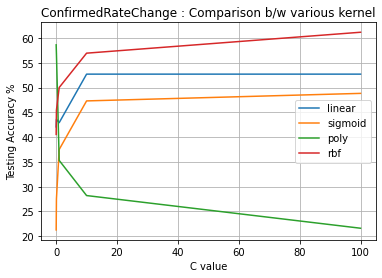

In [0]:
# import matplotlib.pyplot as plt
plt.figure()
for k_val,k_name in enumerate(kernel_name):
      plt.plot(C,kernel_custom[k_val],label=k_name)

plt.title('ConfirmedRateChange : Comparison b/w various kernel')
plt.legend()
plt.grid(True)
plt.xlabel('C value')
plt.ylabel('Testing Accuracy %')
plt.show()

In [0]:
#best kernel is rbf, plotting C value vs testing accuracy for both custom and scikit implementations
C = [0.01,0.1,1,10,100]
#for each kernel , different C values accuracy
kernel_best_custom = [0]*len(C) 
kernel_best_scikit = [0]*len(C) 

for c_id,c_val in enumerate(C):
    kernel_best_scikit[c_id] = run_model(SVC(C=c_val, kernel='rbf'))
    kernel_best_custom[c_id] = run_prediction(run_custom_SVM(Custom_SVM(rbf,C=c_val)))

0.4251901944209637
0.4239864864864865
240 out of 592 predictions correct
Accuracy : 40.54
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       157
           1       1.00      0.29      0.45       435
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.41       592
   macro avg       0.38      0.20      0.25       592
weighted avg       0.97      0.41      0.54       592

Confusion Matrix:
[[114   0   3   8  32]
 [ 12 126 107 103  87]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.554945054945055
0.5118243243243243
269 out of 592 predictions correct
Accuracy : 45.44
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       145
           1       0.99      0.35      0.51       362
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.29      0.40      0.33        85

    accuracy                           0.45       592
   macro avg       0.43      0.30      0.33       592
weighted avg       0.86      0.45      0.56       592

Confusion Matrix:
[[110   0   2   4  29]
 [ 16 125  99  66  56]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   1   9  41  34]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6276415891800508
0.5777027027027027
296 out of 592 predictions correct
Accuracy : 50.00
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       144
           1       0.60      0.62      0.61       120
           2       0.02      1.00      0.04         2
           3       0.31      0.52      0.39        65
           4       0.63      0.29      0.39       261

    accuracy                           0.50       592
   macro avg       0.48      0.64      0.45       592
weighted avg       0.64      0.50      0.54       592

Confusion Matrix:
[[110   0   2   4  28]
 [  1  75  39   5   0]
 [  0   0   2   0   0]
 [  0   3  12  34  16]
 [ 15  48  55  68  75]]
0.680050718512257
0.5945945945945946
337 out of 592 predictions correct
Accuracy : 56.93
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       145
           1       0.68      0.63      0.66       136
           2       0.35      0.51  

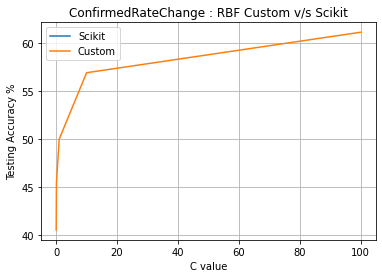

<Figure size 432x288 with 0 Axes>

In [0]:
# import matplotlib.pyplot as plt
plt.figure()
plt.plot(C,kernel_best_scikit,label='Scikit')
plt.plot(C,kernel_best_custom,label='Custom')

plt.title('ConfirmedRateChange : RBF Custom v/s Scikit')
plt.legend()
plt.grid(True)
plt.xlabel('C value')
plt.ylabel('Testing Accuracy %')
plt.show()
plt.savefig('ConfirmedRateChange_RBF_Custom_to_Scikit.png')

##Analysis with Custom SVM:

### Predicting : 'DeathsRateChange'
```
Linear Kernel
C = 0.01 : 414  out of 592 correct, ie, 69.93%
C = 0.1 : 418 out of 592 correct, ie, 70.61%
C = 1 : 420  out of 592 correct, ie, 70.95%
C = 10 : 420  out of 592 correct, ie, 70.95%
C = 100 :  421 out of 592 correct, ie, 71.11%
```

```
Sigmoid Kernel
C = 0.01 :  404 out of 592 correct, ie, 68.24%
C = 0.1 : 403 out of 592 correct, ie, 68.07%
C = 1 : 409 out of 592 correct, ie, 69.09%
C = 10 : 413 out of 592 correct, ie, 69.76%
C = 100 : 337 out of 592 correct, ie, 56.93%
```

```
Polynominal Kernel, degree = 2
C = 0.01 : 422 out of 592 correct, ie, 71.28%
C = 0.1 : 415 out of 592 correct, ie, 70.10%
C = 1 :  408 out of 592 correct, ie, 68.92%
C = 10 : 256 out of 592 correct, ie, 43.24%
C = 100 :  76 out of 592 correct, ie, 12.84%
```

```
Gaussian Kernel
C = 0.01 :  399 out of 592 correct, ie, 67.4%
C = 0.1 : 405 out of 592 correct, ie, 68.41%
C = 1 : 413 out of 592 correct, ie, 69.76%
C = 10 : 408 out of 592 correct, ie, 68.92%
C = 100 : 401 out of 592 correct, ie, 67.74%
```

### Predicting : 'ConfirmedRateChange'
```
Linear Kernel
C = 0.01 :  249 out of 592 correct, ie, 42.06%
C = 0.1 : 258 out of 592 correct, ie, 43.58%
C = 1 :  254 out of 592 correct, ie, 42.90%
C = 10 :  312 out of 592 correct, ie, 52.70%
C = 100 :  312 out of 592 correct, ie, 52.70%
```

```
Sigmoid Kernel
C = 0.01 :  126 out of 592 correct, ie, 21.28%
C = 0.1 : 163 out of 592 correct, ie, 27.53%
C = 1 : 222 out of 592 correct, ie, 37.50%
C = 10 : 280 out of 592 correct, ie, 47.30%
C = 100 : 289 out of 592 correct, ie, 48.82%
```

```
Polynominal Kernel, degree = 2
C = 0.01 : 347 out of 592 correct, ie, 58.61%
C = 0.1 : 336 out of 592 correct, ie, 56.76%
C = 1 :  209 out of 592 correct, ie, 35.30%
C = 10 : 167 out of 592 correct, ie, 28.21%
C = 100 :  128 out of 592 correct, ie, 21.62%
```

```
Gaussian Kernel
C = 0.01 :  231 out of 592 correct, ie, 39.02%
C = 0.1 : 334 out of 592 correct, ie, 56.42%
C = 1 : 347 out of 592 correct, ie, 58.61%
C = 10 : 354 out of 592 correct, ie, 59.80%
C = 100 : 347 out of 592 correct, ie, 58.61%
```